In [84]:
import polars as pl
import pandas as pd
import numpy as np
from enum import Enum
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Input,  TimeDistributed, concatenate
from keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import matplotlib.pyplot as plt

columns_to_normalize = ["close", "ema5", "ema20" , "macd520"]

def read_data(train_file = 'train_data.csv', val_file = 'val_data.csv', test_file = 'test_data.csv'):
    train_data = pl.read_csv(train_file)
    val_data = pl.read_csv(val_file)
    test_data = pl.read_csv(test_file)
    return train_data, val_data, test_data

#get data of x and y and return x and y, slice y
def extract_y(data):
    y = data['next_5_min']
    x = data.drop('next_5_min')
    return x,y


#we should not use min max scale cause the max changing over the time.
#we need to deal with two kinds of things : 1. train data - we need to create a scaler and fit it to the train, and then create a normalized data , 2. test/validation data - we should get as input the scaler of the train, and do normalize by him
def min_max_scaler(data):
    scaler = preprocessing.MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def z_score_normalize(data):
    scaler = preprocessing.StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler
    
def scale_back(data, scaler):
    return scaler.inverse_transform(data)

def normalized_x_y(x: pl.DataFrame, y: pl.DataFrame, columns_to_normalize: list):
    # Convert Polars DataFrame to NumPy array for normalization
    x_values = x.select(columns_to_normalize).to_numpy()
    y_values = y.to_numpy().reshape(-1, 1)
    # Normalize
    normalized_x_values, scaler_x = z_score_normalize(x_values)
    normalized_y_values, scaler_y = z_score_normalize(y_values)
    # Convert back to Polars DataFrame
    normalized_x = pl.DataFrame(normalized_x_values, schema=columns_to_normalize)
    normalized_y = pl.DataFrame(normalized_y_values, schema=['normalized_y'])

    return normalized_x, normalized_y, scaler_x, scaler_y

In [85]:
train_data, val_data, test_data = read_data()
x_train, y_train = extract_y(train_data)
x_val, y_val = extract_y(val_data)
x_test, y_test = extract_y(test_data)


In [86]:
# Split data to train val and test and normalize the data
x_train, y_train, x_train_scaler, y_train_scaler = normalized_x_y(x_train, y_train, columns_to_normalize)
x_val, y_val, x_val_scaler, y_val_scaler = normalized_x_y(x_val, y_val, columns_to_normalize)
x_test, y_test, x_test_scaler, y_test_scaler = normalized_x_y(x_test, y_test, columns_to_normalize)
print(x_test[:3])
print(y_test[:3])

shape: (3, 4)
┌───────────┬───────────┬───────────┬───────────┐
│ close     ┆ ema5      ┆ ema20     ┆ macd520   │
│ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.998162 ┆ -0.99737  ┆ -0.997994 ┆ 0.166266  │
│ -0.998131 ┆ -0.99739  ┆ -0.997658 ┆ 0.054219  │
│ -0.999289 ┆ -0.998367 ┆ -0.998081 ┆ -0.120579 │
└───────────┴───────────┴───────────┴───────────┘
shape: (3, 1)
┌──────────────┐
│ normalized_y │
│ ---          │
│ f64          │
╞══════════════╡
│ -0.996348    │
│ -1.000842    │
│ -0.99807     │
└──────────────┘


In [87]:
history_points = 10
day_size = 75 #the number of 5 min intervals
model = Sequential()
model.add(LSTM(50, input_shape=(history_points, 4)))
model.add(Dropout(0.2))
# Add Dense layer
model.add(Dense(64, activation='sigmoid'))

# Add output Dense layer
model.add(Dense(1, activation='linear'))

# Compile the model
adam = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='mse')

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [88]:
def prepare_lstm_data(x, y, history_points, day_size):
    x_sequences = create_sequences(x, history_points, day_size)
    y_sequences = create_target_sequences(y, history_points, day_size)
    return x_sequences, y_sequences

def create_sequences(data, history_points, day_size):
    sequences = []
    
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate sequences within the current day
        for i in range(day_start, day_end - history_points + 1):
            sequences.append(data[i:i + history_points])
    
    return np.array(sequences)

#creating y data
def create_target_sequences(data, history_points, day_size):
    target_sequences = []
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate target sequences within the current day
        for i in range(day_start+history_points-1, day_end ):
            target_sequences.append(data[i])  # Get the y of the last element in the sequence(the y of the 10 number)
    return np.array(target_sequences).reshape(-1, 1, 1)  # Reshape to (batch_size, 1, 1)

x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )

# Train the model
model.fit(x=x_train_prepared, y=y_train_prepared, batch_size=25, epochs=1, verbose=0)

# Predict and evaluate
y_val_predicted = model.predict(x_val_prepared)

y_val_predicted = y_val_scaler.inverse_transform(y_val_predicted)
y_val = y_val_scaler.inverse_transform(y_val)



x_train is (92100, 4)
y_train is (92100, 1)
x_train_prepared is (81048, 10, 4)
y_train_prepared is (81048, 1, 1)
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [89]:
#convert back to polars
print(x_val_prepared.shape)
print(y_val_predicted.shape)
print("y_val_predicted:",y_val_predicted[1])
print("y_val",y_val[1])
# Compute RMSE
rmse = np.sqrt(np.mean(np.square(y_val_prepared - y_val_predicted)))

# # Compute scaled RMSE
scaled_rmse = rmse / (np.max(y_val_predicted) - np.min(y_val_predicted)) * 100

print("Adjusted Prediction Root Mean Squared Error for real data: {:.2f} %".format(scaled_rmse))

(17358, 10, 4)
(17358, 1)
y_val_predicted: [8711.65]
y_val [8740.75]
Adjusted Prediction Root Mean Squared Error for real data: 108.49 %


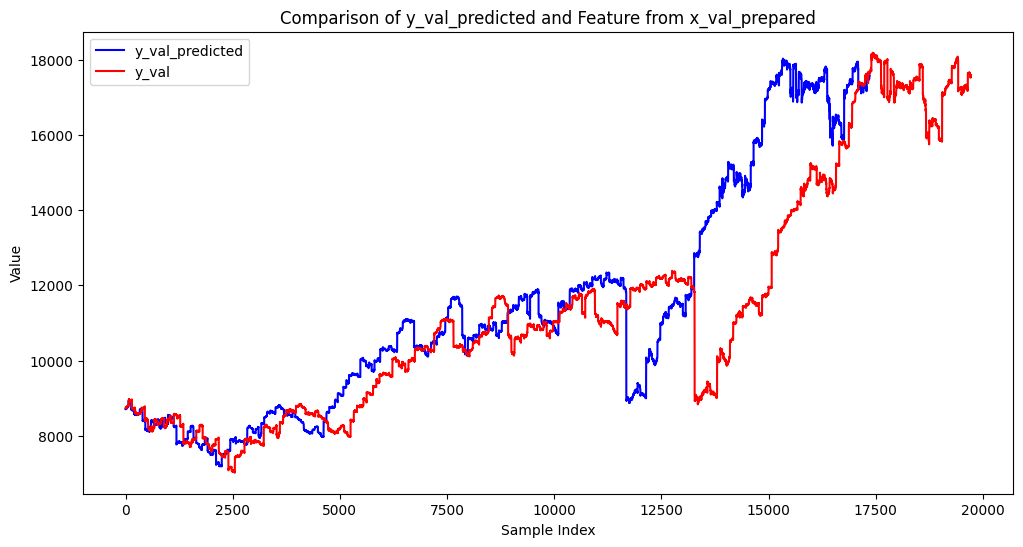

In [93]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot y_val_predicted
plt.plot(y_val_predicted, color='blue', label='y_val_predicted')

# Plot feature from x_val_prepared
plt.plot(y_val, color='red', label='y_val')

# Add labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_val_predicted and Feature from x_val_prepared')
plt.legend()

# Show plot
plt.show()